<a href="https://cognitiveclass.ai"><img src = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/IDSNlogo.png" width = 400> </a>

<h1 align=center><font size = 6>Segmenting and Clustering Neighborhoods in Toronto</font></h1>


### 1. Dataset Exploration

In [1]:
# Import the Library for Dataset
import pandas as pd
import requests
from bs4 import BeautifulSoup

In this assignment I will explore the neighborhood of Toronto and cluster it into several group that has similar characteristic.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(url).text
soup = BeautifulSoup(html_data,"html5lib")

This url is used to determine the neighborhood of each postal code.

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [4]:
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
toronto_data = pd.DataFrame(table_contents)
toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


External CSV file is used to determine the detail location (latitude and longitude) of each postal code.

In [6]:
geospatial_data = pd.read_csv('Geospatial_Coordinates.csv')
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
latitude = []
longitude = []
for i in range(len(toronto_data)):
    pos_code = toronto_data.loc[i,'PostalCode']
    latitude.append(geospatial_data[geospatial_data['Postal Code'] == pos_code].Latitude.values[0])
    longitude.append(geospatial_data[geospatial_data['Postal Code'] == pos_code].Longitude.values[0])
toronto_data['Latitude'] = latitude
toronto_data['Longitude'] = longitude
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### 2. Dataset Visualization

Now, I will visualize each borough in the map using the library of geospatial.

In [8]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

In [9]:
address = 'Toronto'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address, timeout=10)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [10]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto

### 3. Neighborhoods Exploration

Foursquare is used to get the detail venue of each borough for the analysis step. In this code I use 100 for the limit venue each borough and 500m for the radius.

In [11]:
CLIENT_ID = 'NEAFK5P3POABAW4CAAMXHEK00YBBGCC4ELKDUFTK512SX33L' # your Foursquare ID
CLIENT_SECRET = 'YZXTRDUFF24H1GXBVNP5YR2P2AFJVVOOTLALPET51WUCSHER' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NEAFK5P3POABAW4CAAMXHEK00YBBGCC4ELKDUFTK512SX33L
CLIENT_SECRET:YZXTRDUFF24H1GXBVNP5YR2P2AFJVVOOTLALPET51WUCSHER


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# type your answer here
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Here is the top 5 data of toronto venue near each borough.

In [14]:
print(toronto_venues.shape)
toronto_venues.head()

(2114, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [15]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale West,5,5,5,5,5,5
"Willowdale, Newtonbrook",2,2,2,2,2,2
Woburn,4,4,4,4,4,4


In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


### 4. Neighborhood Analysis

One-Hot-encoding is used to make the process much easier for the clustering. But before the clustering process begin, I will use the mean value of each venue categories for every borough to determine each characteristic of each borough. So we can easily find the characteristic for every borough even if the number venue of each borough is different.

In [17]:
import numpy as np

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
toronto_onehot.shape

(2114, 269)

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
toronto_grouped.shape

(100, 269)

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1               Skating Rink   0.2
2  Latin American Restaurant   0.2
3             Breakfast Spot   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.22
1        Pharmacy  0.11
2             Pub  0.11
3  Sandwich Place  0.11
4            Pool  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0              Bank  0.10
1       Coffee Shop  0.10
2          Pharmacy  0.05
3       Supermarket  0.05
4  Sushi Restaurant  0.05


----Bayview Village----
                             venue  freq
0                             Café  0.25
1               Chinese Restaurant  0.25
2                             Bank  0.25
3              Japanese Restaurant  0.25
4  Molecular Gastronomy Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0       Italian Restaurant  0.08

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Clothing Store,Skating Rink
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Pool
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sushi Restaurant,Shopping Mall,Sandwich Place
3,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Escape Room
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Restaurant


### 5. Cluster Neighborhoods

Before clustering process, we have to find the number of cluster that will give a great separation of Toronto. To find the number of cluster I used the elbow method which will show WCSS (Within Cluster Sum of Squared) of each number cluster. I will select the last significant change of WCSS from the plot which will give the best seperation to the data. 

In [25]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

C:\Users\TUF GAMING\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


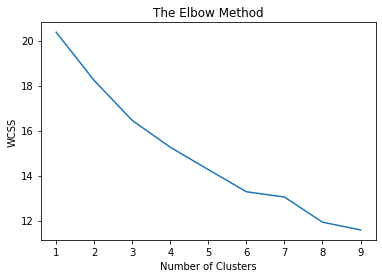

In [26]:
wcss=[]
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

for i in range(1,10):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Based on the plot, I will choose 6 as the number of cluster because the decreasing of WCSS after that is not significant. 

In [27]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 5])

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,5.0,Park,Fast Food Restaurant,Construction & Landscaping,Food & Drink Shop,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,Intersection,Pizza Place,Coffee Shop,Hockey Arena
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Pub,Bakery,Park,Theater
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Gift Shop,Event Space,Coffee Shop
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Nightclub,Bar,Beer Bar


In [29]:
toronto_merged['Cluster Labels'].value_counts()

1.0    80
5.0    15
3.0     2
2.0     1
4.0     1
0.0     1
Name: Cluster Labels, dtype: int64

Now, I will drop borough with NaN value. I dont know how could it be but it can make the clustering process cannot work well.

In [30]:
toronto_merged[toronto_merged['Cluster Labels'].isna()==True]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
toronto_venues[toronto_venues['Neighborhood']=='Islington Avenue']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [43]:
toronto_venues[toronto_venues['Neighborhood']=='York Mills, Silver Hills']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [42]:
toronto_venues[toronto_venues['Neighborhood']=='Upper Rouge']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


We can see that the foursquare doesn't work well so there is no venue was founded in that area.

In [31]:
toronto_merged = toronto_merged.drop(index=toronto_merged[toronto_merged['Cluster Labels'].isna()==True].index.values).reset_index(drop=True)

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster)],
        fill=True,
        fill_color=rainbow[round(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 6. Examine Cluster

#### Cluster 1 (Purple)

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,"Rouge Hill, Port Union, Highland Creek",0.0,Bar,Women's Store,Drugstore,Discount Store,Distribution Center


#### Cluster 2 (Blue)

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Victoria Village,1.0,Portuguese Restaurant,Intersection,Pizza Place,Coffee Shop,Hockey Arena
2,"Regent Park, Harbourfront",1.0,Coffee Shop,Pub,Bakery,Park,Theater
3,"Lawrence Manor, Lawrence Heights",1.0,Clothing Store,Furniture / Home Store,Gift Shop,Event Space,Coffee Shop
4,Ontario Provincial Government,1.0,Coffee Shop,Sushi Restaurant,Nightclub,Bar,Beer Bar
5,"Malvern, Rouge",1.0,Fast Food Restaurant,Women's Store,Drugstore,Diner,Discount Store
...,...,...,...,...,...,...,...
93,"St. James Town, Cabbagetown",1.0,Coffee Shop,Italian Restaurant,Pub,Café,Pizza Place
94,"First Canadian Place, Underground city",1.0,Coffee Shop,Café,Gym,Deli / Bodega,Sushi Restaurant
96,Church and Wellesley,1.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant
97,Enclave of M4L,1.0,Light Rail Station,Gym / Fitness Center,Spa,Auto Workshop,Brewery


#### Cluster 3 (Cyan)

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
95,"The Kingsway, Montgomery Road, Old Mill North",2.0,River,Women's Store,Dessert Shop,Ethiopian Restaurant,Escape Room


#### Cluster 4 (Green)

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
55,"Humberlea, Emery",3.0,Baseball Field,Women's Store,Discount Store,Distribution Center,Dog Run
98,"Old Mill South, King's Mill Park, Sunnylea, Hu...",3.0,Baseball Field,Women's Store,Discount Store,Distribution Center,Dog Run


#### Cluster 5 (Orange)

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,Scarborough Village,4.0,Playground,Women's Store,Donut Shop,Dim Sum Restaurant,Diner


#### Cluster 6 (Red)

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Parkwoods,5.0,Park,Fast Food Restaurant,Construction & Landscaping,Food & Drink Shop,Doner Restaurant
13,Woodbine Heights,5.0,Park,Curling Ice,Beer Store,Athletics & Sports,Skating Rink
20,Caledonia-Fairbanks,5.0,Park,Women's Store,Pool,Ethiopian Restaurant,Escape Room
34,The Danforth East,5.0,Park,Intersection,Convenience Store,Drugstore,Discount Store
39,Downsview East,5.0,Park,Bus Stop,Airport,Donut Shop,Diner
47,"North Park, Maple Leaf Park, Upwood Park",5.0,Park,Construction & Landscaping,Bakery,Trail,Basketball Court
50,"Willowdale, Newtonbrook",5.0,Park,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store
59,Lawrence Park,5.0,Park,Swim School,Bus Line,Jewelry Store,Doner Restaurant
62,Weston,5.0,Park,Convenience Store,Ethiopian Restaurant,Escape Room,Electronics Store
64,York Mills West,5.0,Park,Construction & Landscaping,Convenience Store,Escape Room,Electronics Store
